# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 4.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=039fa85a92884901c9601c60340b9c1214ccc4eec2a6e78b317dbb0fad3854ff
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 58kB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 2.2MB 7.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210220-cp36-none-any.whl size=52292 sha256=cb4bb47bb11ba5a1943134c7ead20268fdffeb9c2269124f4ca3a60f92ec24ff
  Stored in directory: /root/.cache/pip/wheels/a1/af/2b/42e10bc07a70a2776e1a011d058a952db114a60f7bc8aa2199
  Created wheel for iopath: filename=iopath-0.1.4-cp36-none-any.whl size=15571 sha256=81513d61842372e48823425b8375a99d13807c5c32e3eca8e776e238684e100d
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pi

# Distributions

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



Mounted at /content/drive


# Annotation Distribution

In [2]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [3]:
train = get_dict('train')
test = get_dict('test')
test_offshore = get_dict('test_offshore')
test_inshore = get_dict('test_inshore')

In [ ]:
import itertools
# Total pixel size of bbox in annotations in pictures
def total_ann_size(dataset):
  anns = [pic['annotations'] for pic in dataset if pic['annotations']!= []]
  l_anns = list(itertools.chain(*anns))
  dx = [bbox['bbox'][2] - bbox['bbox'][0] for bbox in l_anns]
  dy = [bbox['bbox'][3] - bbox['bbox'][1] for bbox in l_anns]
  return np.sum(np.array(dx) * np.array(dy))

# Total number of pictures
def total_pictures(dataset):
  return len(dataset)

# Total number of annotations in dataset
def total_annotations(dataset):
  return np.sum([len(pic['annotations']) for pic in dataset])

# Number of pictures w/0 annotation in dataset
def pictures_no_annotations(dataset):
  return np.sum([pic['annotations'] == [] for pic in dataset])

# Number of pictures w/ annotations in dataset
def pictures_annotations(dataset):
  return np.sum([pic['annotations'] != [] for pic in dataset])

In [ ]:
print(total_pictures(train))
print(total_pictures(test))
print(total_pictures(test_offshore))
print(total_pictures(test_inshore))

6000
3000
2234
766


In [ ]:
print(total_annotations(train))
print(total_annotations(test))
print(total_annotations(test_offshore))
print(total_annotations(test_inshore))

3637
2378
1495
883


In [ ]:
# Fraction of pictures w/o annotations
print(pictures_no_annotations(train) / total_pictures(train))
print(pictures_no_annotations(test) / total_pictures(test))
print(pictures_no_annotations(test_offshore) / total_pictures(test_offshore))
print(pictures_no_annotations(test_inshore) / total_pictures(test_inshore))

0.8128333333333333
0.7546666666666667
0.7229185317815577
0.8472584856396866


In [ ]:
# Fraction of pictures w/ annotations
print(pictures_annotations(train) / total_pictures(train))
print(pictures_annotations(test) / total_pictures(test))
print(pictures_annotations(test_offshore) / total_pictures(test_offshore))
print(pictures_annotations(test_inshore) / total_pictures(test_inshore))

0.18716666666666668
0.24533333333333332
0.27708146821844226
0.15274151436031333


In [ ]:
# Annotations per picture | picture has annotation
print(total_annotations(train) / pictures_annotations(train))
print(total_annotations(test) / pictures_annotations(test))
print(total_annotations(test_offshore) / pictures_annotations(test_offshore))
print(total_annotations(test_inshore) / pictures_annotations(test_inshore))

3.238646482635797
3.2309782608695654
2.4151857835218093
7.547008547008547


In [ ]:
# Fraction of pixel size of annotation to picture | picture has annotation
print(total_ann_size(train) / (800*800*pictures_annotations(train)))
print(total_ann_size(test) / (800*800*pictures_annotations(test)))
print(total_ann_size(test_offshore) / (800*800*pictures_annotations(test_offshore)))
print(total_ann_size(test_inshore) / (800*800*pictures_annotations(test_inshore)))

0.001659640750222618
0.0023314686650815217
0.0021962818053311794
0.003046688034188034


# Pixel Distribution

In [4]:
import cv2
from matplotlib import pyplot as plt

In [5]:
def distribution(dataset, num):
  sample = random.sample(dataset, k = num)
  res = np.zeros(256)
  for pic in sample:
    image_bw =cv2.imread(pic['file_name'],0)
    temp = np.histogram(image_bw.ravel(), 256, [0,256])[0]
    res += temp
  return res

In [23]:
num_samples = 500

In [24]:
p1 = distribution(train, num_samples)
p2 = distribution(test, num_samples)
p3 = distribution(test_offshore, num_samples)
p4 = distribution(test_inshore, num_samples)

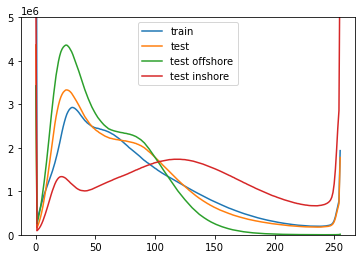

In [29]:
plt.plot(p1, label = "train")
plt.plot(p2, label = 'test')
plt.plot(p3, label = 'test offshore')
plt.plot(p4, label = 'test inshore')
plt.legend()
plt.ylim(ymax = 0.5*1e7, ymin = 0)
plt.show()

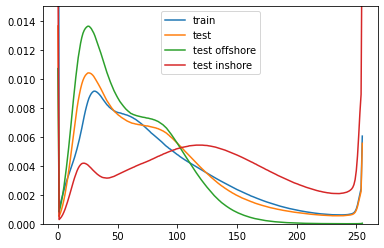

In [37]:
plt.plot(p1 / np.sum(p1), label = "train")
plt.plot(p2 / np.sum(p2), label = 'test')
plt.plot(p3 / np.sum(p3), label = 'test offshore')
plt.plot(p4 / np.sum(p4), label = 'test inshore')
plt.legend()
plt.ylim(ymax = 0.0150, ymin = 0)
plt.show()